# LEVEL OF ACCIDENTALITY IN BOGOTA COLOMBIA IN THE YEAR 2019

## INTRODUCTION

Traffic accidents today represent one of the biggest public health problems worldwide. Leaving not alone, losses of loved ones and damages emotional, but also very high economic costs for medical treatments and surgical, material damage. Therefore, the need arises to know what the causes are that originate traffic accidents and the factors that intervene in the development of themselves. In order to be able to generate preventive and corrective measures that decrease the probabilities of its occurrence. In Bogota in 2019 there were around 34,998 accidents, some slight but others fatal, for which it is necessary to try to establish the multiple causes that can generate an accident. One of the main causes is the consumption of alcoholic beverages, so this work will be based on establishing whether in the neighborhoods of the city of Bogota where most accidents occur is because there are several places where alcoholic beverages can be consumed.

## DATA

In the city of Bogota, the information on accidents that occurred from 2011 to 2019 is sought. For this study, only data from 2019 will be used. After this, the latitudes and longitudes of each of the neighborhoods will be obtained for thus to be able to classify them better.
In addition, we will use the Foursquare API to obtain the data of the place of each of the neighborhoods of Bogotá. Foursquare has one of the largest databases of 105+ million places and more than 125,000 developers use this application. Foursquare API provides many categories of place data, for this study we are interested in knowing the establishments where alcoholic beverages are sold.



In [140]:
# import the libraries
import pandas as pd
import numpy as np
import folium # map rendering library
import geocoder # import geocoder
from sklearn.cluster import KMeans # import k-means from clustering stage
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

In [141]:
# Extract data on accident levels in Bogota in 2019
df = pd.read_excel(r'C:\Users\Gabriel\Documents\IBM DATA SCIENCE\Ejercicio FInal\Localidades_Bogota_Accidentes_2019.xlsx')
df.head()

,CODIGO_SINIESTRO,FECHA,HORA,GRAVEDAD,CLASE,CHOQUE_CON,OBJETO_FIJO,DIRECCION,TOTAL_MUERTOS,TOTAL_HERIDOS,LOCALIDAD,LATITUD,LONGITUD,DISENO_LUGAR
0,10471900,01/01/2019,02:30:00,Solo Daños,Choque,Vehiculo,NaN,AV AVENIDA CIUDAD DE QUITO-CL 45 2,0,0,Teusaquillo,4.6419,-74.0829,Tramo de Via
1,10471901,01/01/2019,06:25:00,Con Heridos,Choque,Vehiculo,NaN,AV AVENIDA CIUDAD DE CALI-CL 10 2,0,1,Kennedy,4.6435,-74.1533,Interseccion
2,10471931,01/01/2019,08:02:00,Solo Daños,Choque,Vehiculo,NaN,KR 95G-CL 90A 2,0,0,Engativá,4.6975,-74.1123,Tramo de Via
3,10474414,01/01/2019,11:50:00,Solo Daños,Choque,Objeto Fijo,Vehiculo estacionado,KR 6-CL 9 2,0,0,Santa Fé,4.5961,-74.0418,Tramo de Via
4,10474421,01/01/2019,18:50:00,Solo Daños,Choque,Vehiculo,NaN,KR 14-CL 100 2,0,0,Usaquén,4.7352,-74.0183,Tramo de Via


# Analyzing Data

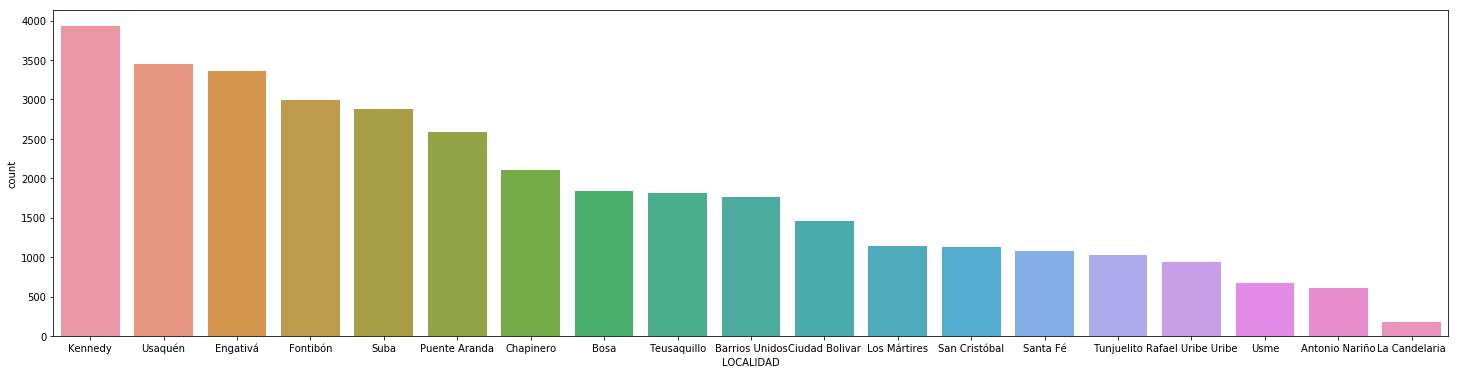

In [142]:
# Show which are the neighborhoods with the highest accident rate
plt.figure(figsize=(25, 6))
sns.countplot(x='LOCALIDAD',data=df,order = df['LOCALIDAD'].value_counts().index)

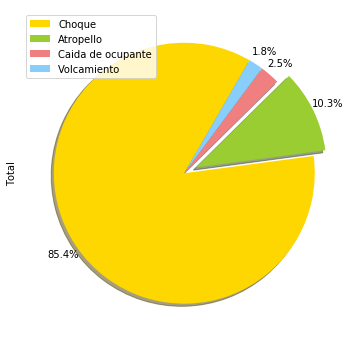

In [143]:
#Show which is the highest accident rate per class

df_Clase = df.groupby(['CLASE']).size().reset_index()
df_Clase = df_Clase.rename(columns={0:'Total'})
df_Clase_sort = df_Clase.sort_values(by="Total",ascending=False).head(4).reset_index(drop=True)
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0.1, 0, 0] # ratio for each continent with which to offset each wedge.
df_Clase_sort['Total'].plot(kind='pie',
                      figsize=(15,6),
                      autopct="%1.1f%%",
                      startangle=60,
                      shadow=True,
                      labels=None,
                      pctdistance=1.12,
                      colors = colors_list,
                      explode=explode_list
                      )
plt.legend(labels=df_Clase_sort.CLASE, loc='best') 
plt.show()

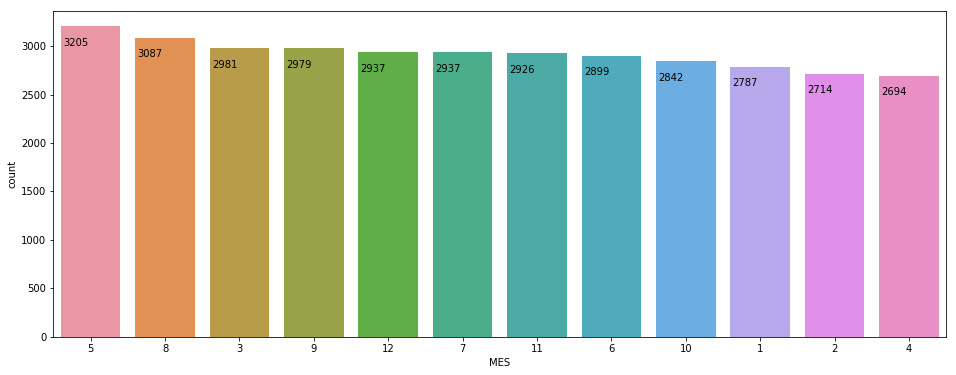

In [144]:
#Show which was the month of the year 2019 with the highest number of accidents
df['MES'] = pd.DatetimeIndex(df['FECHA']).month
plt.figure(figsize=(16, 6))
ax= sns.countplot(x='MES',data=df,order = df['MES'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=10)
plt.show()

# PREPARING DATA

In [145]:
# delete columns that I will not use in the analysis
df.drop(['CODIGO_SINIESTRO','MES','DIRECCION','OBJETO_FIJO'],axis=1,inplace=True)
df.head()

,FECHA,HORA,GRAVEDAD,CLASE,CHOQUE_CON,TOTAL_MUERTOS,TOTAL_HERIDOS,LOCALIDAD,LATITUD,LONGITUD,DISENO_LUGAR
0,01/01/2019,02:30:00,Solo Daños,Choque,Vehiculo,0,0,Teusaquillo,4.6419,-74.0829,Tramo de Via
1,01/01/2019,06:25:00,Con Heridos,Choque,Vehiculo,0,1,Kennedy,4.6435,-74.1533,Interseccion
2,01/01/2019,08:02:00,Solo Daños,Choque,Vehiculo,0,0,Engativá,4.6975,-74.1123,Tramo de Via
3,01/01/2019,11:50:00,Solo Daños,Choque,Objeto Fijo,0,0,Santa Fé,4.5961,-74.0418,Tramo de Via
4,01/01/2019,18:50:00,Solo Daños,Choque,Vehiculo,0,0,Usaquén,4.7352,-74.0183,Tramo de Via


In [146]:
# Create final dataframe with the sum of accidents by neighborhood
df_final= df[['LOCALIDAD','LATITUD','LONGITUD']]
df_final = df_final.groupby(['LOCALIDAD','LATITUD','LONGITUD']).size().reset_index()
df_final = df_final.rename(columns={0:'TOTAL_ACCIDENTS','LOCALIDAD':'NEIGHBOURHOOD'})
df_final

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS
0,Antonio Nariño,4.5901,-74.1034,614
1,Barrios Unidos,4.6787,-74.0787,1769
2,Bosa,4.6171,-74.1899,1841
3,Chapinero,4.6459,-74.0634,2102
4,Ciudad Bolivar,4.5360,-74.1388,1458
5,Engativá,4.6975,-74.1123,3366
6,Fontibón,4.6785,-74.1410,2998
7,Kennedy,4.6435,-74.1533,3935
8,La Candelaria,4.5944,-74.0741,187
9,Los Mártires,4.6045,-74.0900,1143


In [147]:
df_final.shape

(19, 4)

In [148]:
# Get the coordinates of the city of Bogota
address = "Bogota, CO"

geolocator = Nominatim(user_agent="bogota_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogota city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogota city are 4.6533326, -74.083652.


In [149]:
# Show on the map the different neighborhoods of the city of Bogota

map_bogota = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, NEIGHBOURHOOD in zip(
        df_final['LATITUD'], 
        df_final['LONGITUD'],  
        df_final['NEIGHBOURHOOD']):
    label = label = '{}'.format(NEIGHBOURHOOD)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
       color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  

map_bogota

# Define Foursquare Credentials and Version

In [150]:
# Enter credentials of the Foursquare application

CLIENT_ID = 'M5T0KVE2XEX5SJSQ1TRP40TAA320KZJEDMGT3NY1OAUBT2R5' # your Foursquare ID
CLIENT_SECRET = '4XVMTSWSQPTK2NKEURY51I35C1ZRGO3COJQOLS3UXCU4NFKL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [151]:
# Function that returns the different types of category that exist in each of the Toronto neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [152]:
# run the function "getNearbyVenues" on each neighborhood and create a new dataframe called Toronto_venues.

Bogota_venues = getNearbyVenues(names=df_final['NEIGHBOURHOOD'],
                                   latitudes=df_final['LATITUD'],
                                   longitudes=df_final['LONGITUD']
                                  )

Antonio Nariño
Barrios Unidos
Bosa
Chapinero
Ciudad Bolivar
Engativá
Fontibón
Kennedy
La Candelaria
Los Mártires
Puente Aranda
Rafael Uribe Uribe
San Cristóbal
Santa Fé
Suba
Teusaquillo
Tunjuelito
Usaquén
Usme


In [153]:
# Check how many venues were returned for each neighborhood
Bogota_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Antonio Nariño,11,11,11,11,11,11
Barrios Unidos,15,15,15,15,15,15
Bosa,2,2,2,2,2,2
Chapinero,85,85,85,85,85,85
Engativá,5,5,5,5,5,5
Fontibón,11,11,11,11,11,11
Kennedy,8,8,8,8,8,8
La Candelaria,65,65,65,65,65,65
Los Mártires,7,7,7,7,7,7


In [154]:
# Check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Bogota_venues['Venue Category'].unique())))

There are 87 uniques categories.


### Get dummies of column 'Venue Category' for Each Neighborhood

In [155]:
df_Bogota = pd.get_dummies(Bogota_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_Bogota['Neighbourhood'] = Bogota_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [df_Bogota.columns[-1]] + list(df_Bogota.columns[:-1])
df_Bogota = df_Bogota[fixed_columns]
df_Bogota.head()


,Neighbourhood,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant
0,Antonio Nariño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Antonio Nariño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Antonio Nariño,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Antonio Nariño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Antonio Nariño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
df_Bogota_group = df_Bogota.groupby('Neighbourhood').mean().reset_index()
df_Bogota_group

,Neighbourhood,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant
0,Antonio Nariño,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
1,Barrios Unidos,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
2,Bosa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.000000,0.000,0.000000,0.000000
3,Chapinero,0.047059,0.000000,0.000000,0.000000,0.011765,0.023529,0.047059,0.023529,0.011765,...,0.011765,0.0,0.023529,0.011765,0.023529,0.023529,0.011765,0.000,0.011765,0.023529
4,Engativá,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
5,Fontibón,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
6,Kennedy,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000
7,La Candelaria,0.000000,0.046154,0.030769,0.030769,0.030769,0.015385,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.015385,0.015385
8,Los Mártires,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
9,Puente Aranda,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000


In [157]:
num_top_venues = 10

for hood in df_Bogota_group['Neighbourhood']:
    print("----"+hood+"----")
    temp = df_Bogota_group[df_Bogota_group['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antonio Nariño----
                     venue  freq
0               Restaurant  0.18
1                BBQ Joint  0.18
2  Comfort Food Restaurant  0.09
3               Food Court  0.09
4            Deli / Bodega  0.09
5           Clothing Store  0.09
6       Seafood Restaurant  0.09
7            Shopping Mall  0.09
8        Convenience Store  0.09
9            Movie Theater  0.00


----Barrios Unidos----
                  venue  freq
0   Fried Chicken Joint  0.13
1        Sandwich Place  0.07
2          Burger Joint  0.07
3  Fast Food Restaurant  0.07
4           Pizza Place  0.07
5            Restaurant  0.07
6        Soccer Stadium  0.07
7           Coffee Shop  0.07
8                  Café  0.07
9     College Bookstore  0.07


----Bosa----
                   venue  freq
0                   Park   0.5
1            Supermarket   0.5
2       Arepa Restaurant   0.0
3          Movie Theater   0.0
4  Performing Arts Venue   0.0
5                 Notary   0.0
6         Nightlife Spot   

### Write a function to sort the venues in descending order.

In [158]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [159]:
# Show the top 10 of common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = df_Bogota_group['Neighbourhood']

for ind in np.arange(df_Bogota_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_Bogota_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antonio Nariño,BBQ Joint,Restaurant,Seafood Restaurant,Clothing Store,Comfort Food Restaurant,Food Court,Convenience Store,Deli / Bodega,Shopping Mall,Vegetarian / Vegan Restaurant
1,Barrios Unidos,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Creperie,College Bookstore,Coffee Shop,Pizza Place,Burger Joint,Plaza
2,Bosa,Park,Supermarket,Dessert Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega
3,Chapinero,Restaurant,Gay Bar,Coffee Shop,Nightclub,Arepa Restaurant,Bar,Breakfast Spot,Latin American Restaurant,Burger Joint,Caribbean Restaurant
4,Engativá,Shopping Mall,Fried Chicken Joint,Fast Food Restaurant,Bowling Alley,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center
5,Fontibón,Restaurant,Food & Drink Shop,Fried Chicken Joint,Notary,Mexican Restaurant,Shopping Mall,Park,Gym,Hotel,Food
6,Kennedy,BBQ Joint,Donut Shop,Breakfast Spot,Movie Theater,Fast Food Restaurant,Coffee Shop,Thai Restaurant,French Restaurant,Food Court,Comfort Food Restaurant
7,La Candelaria,Café,Restaurant,History Museum,Latin American Restaurant,Italian Restaurant,Mexican Restaurant,Argentinian Restaurant,Art Museum,Coffee Shop,Art Gallery
8,Los Mártires,Shopping Mall,Clothing Store,Skate Park,Boutique,Department Store,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center
9,Puente Aranda,Park,Neighborhood,Bakery,Ice Cream Shop,South American Restaurant,Shopping Mall,Department Store,College Bookstore,Comfort Food Restaurant,Concert Hall


## Cluster Neighborhoods

In [160]:
# set number of clusters
kclusters = 5

df_Bogota_group_clustering = df_Bogota_group.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_Bogota_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 1, 1, 1, 1, 1, 1, 1])

In [166]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Bogota_merged = df_final

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Bogota_merged = Bogota_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='NEIGHBOURHOOD')
Bogota_merged = Bogota_merged[Bogota_merged['Cluster Labels'].notna()]
Bogota_merged['Cluster Labels'] = Bogota_merged['Cluster Labels'].astype(int)
Bogota_merged.head() # check the last columns!


,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antonio Nariño,4.5901,-74.1034,614,1,BBQ Joint,Restaurant,Seafood Restaurant,Clothing Store,Comfort Food Restaurant,Food Court,Convenience Store,Deli / Bodega,Shopping Mall,Vegetarian / Vegan Restaurant
1,Barrios Unidos,4.6787,-74.0787,1769,1,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Creperie,College Bookstore,Coffee Shop,Pizza Place,Burger Joint,Plaza
2,Bosa,4.6171,-74.1899,1841,4,Park,Supermarket,Dessert Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega
3,Chapinero,4.6459,-74.0634,2102,1,Restaurant,Gay Bar,Coffee Shop,Nightclub,Arepa Restaurant,Bar,Breakfast Spot,Latin American Restaurant,Burger Joint,Caribbean Restaurant
5,Engativá,4.6975,-74.1123,3366,1,Shopping Mall,Fried Chicken Joint,Fast Food Restaurant,Bowling Alley,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center


In [167]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bogota_merged['LATITUD'], Bogota_merged['LONGITUD'], Bogota_merged['NEIGHBOURHOOD'], Bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [170]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 0]

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Rafael Uribe Uribe,4.5703,-74.1093,935,0,Arepa Restaurant,Donut Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega,Department Store,Dessert Shop


In [173]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 1].sort_values(by='TOTAL_ACCIDENTS',ascending=False)

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Kennedy,4.6435,-74.1533,3935,1,BBQ Joint,Donut Shop,Breakfast Spot,Movie Theater,Fast Food Restaurant,Coffee Shop,Thai Restaurant,French Restaurant,Food Court,Comfort Food Restaurant
17,Usaquén,4.7352,-74.0183,3450,1,Pub,Burger Joint,Vegetarian / Vegan Restaurant,Dessert Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega
5,Engativá,4.6975,-74.1123,3366,1,Shopping Mall,Fried Chicken Joint,Fast Food Restaurant,Bowling Alley,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center
6,Fontibón,4.6785,-74.1410,2998,1,Restaurant,Food & Drink Shop,Fried Chicken Joint,Notary,Mexican Restaurant,Shopping Mall,Park,Gym,Hotel,Food
14,Suba,4.7569,-74.0888,2874,1,Cocktail Bar,Steakhouse,BBQ Joint,Bar,Lake,Donut Shop,Concert Hall,Convenience Store,Creperie,Cultural Center
10,Puente Aranda,4.6125,-74.1066,2585,1,Park,Neighborhood,Bakery,Ice Cream Shop,South American Restaurant,Shopping Mall,Department Store,College Bookstore,Comfort Food Restaurant,Concert Hall
3,Chapinero,4.6459,-74.0634,2102,1,Restaurant,Gay Bar,Coffee Shop,Nightclub,Arepa Restaurant,Bar,Breakfast Spot,Latin American Restaurant,Burger Joint,Caribbean Restaurant
15,Teusaquillo,4.6419,-74.0829,1810,1,Gym / Fitness Center,Pool,Event Space,Soccer Stadium,Soccer Field,Restaurant,Bowling Alley,Vegetarian / Vegan Restaurant,Deli / Bodega,Comfort Food Restaurant
1,Barrios Unidos,4.6787,-74.0787,1769,1,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Creperie,College Bookstore,Coffee Shop,Pizza Place,Burger Joint,Plaza
9,Los Mártires,4.6045,-74.0900,1143,1,Shopping Mall,Clothing Store,Skate Park,Boutique,Department Store,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center


In [174]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 2].sort_values(by='TOTAL_ACCIDENTS',ascending=False)

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Usme,4.4703,-74.1174,673,2,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega,Department Store


In [175]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 3].sort_values(by='TOTAL_ACCIDENTS',ascending=False)

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,San Cristóbal,4.5646,-74.0833,1135,3,Playground,Coffee Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega,Department Store


In [176]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 4].sort_values(by='TOTAL_ACCIDENTS',ascending=False)

,NEIGHBOURHOOD,LATITUD,LONGITUD,TOTAL_ACCIDENTS,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bosa,4.6171,-74.1899,1841,4,Park,Supermarket,Dessert Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Deli / Bodega
